**Import Library**

In [5]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

warnings.simplefilter("ignore")

**Data preprocessing**

Membuat train, test and validation dataframes


Iterasi melalui direktori gambar dan membuat label kelas dan filepaths untuk membuat dataframe.


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
# Define paths
base_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits"
paths = {
    "bad": os.path.join(base_path, "Bad Quality_Fruits"),
    "good": os.path.join(base_path, "Good Quality_Fruits"),
    "mixed": os.path.join(base_path, "Mixed Qualit_Fruits")
}
filepaths, labels = [], []
# Iterate through quality paths and gather data
for quality, path in paths.items():
    for fruit in os.listdir(path):
        fruit_path = os.path.join(path, fruit)
        for i, img_name in enumerate(os.listdir(fruit_path)):
            img_path = os.path.join(fruit_path, img_name)
            filepaths.append(img_path)
            labels.append(f"{fruit}_mixed" if quality == "mixed" else fruit)

df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

In [3]:
df.head()

,filepaths,labels
0,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
1,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
2,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
3,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
4,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad


In [4]:
df.iloc[0, :].values

array(['../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits/Guava_Bad/IMG_20190822_081045_1.jpg',
       'Guava_Bad'], dtype=object)

In [18]:
df.shape

(19526, 2)

In [19]:
df.dtypes

filepaths    object
labels       object
dtype: object

In [20]:
df['labels']=df['labels'].astype('category')

In [21]:
df['labels'].value_counts()

Pomegranate_Good     5940
Orange_Good          1216
Pomegranate_Bad      1187
Orange_Bad           1159
Guava_Good           1152
Apple_Good           1149
Apple_Bad            1141
Guava_Bad            1129
Banana_Good          1113
Lime_Good            1094
Banana_Bad           1087
Lime_Bad             1085
Banana_mixed          285
Lemon_mixed           278
Guava_mixed           148
Orange_mixed          125
Pomegranate_mixed     125
Apple_mixed           113
Name: labels, dtype: int64

**Exploratory Data Analysis**

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

df['labels'].unique()

['Guava_Bad', 'Lime_Bad', 'Orange_Bad', 'Pomegranate_Bad', 'Banana_Bad', ..., 'Pomegranate_mixed', 'Apple_mixed', 'Guava_mixed', 'Lemon_mixed', 'Banana_mixed']
Length: 18
Categories (18, object): ['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad', ..., 'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']

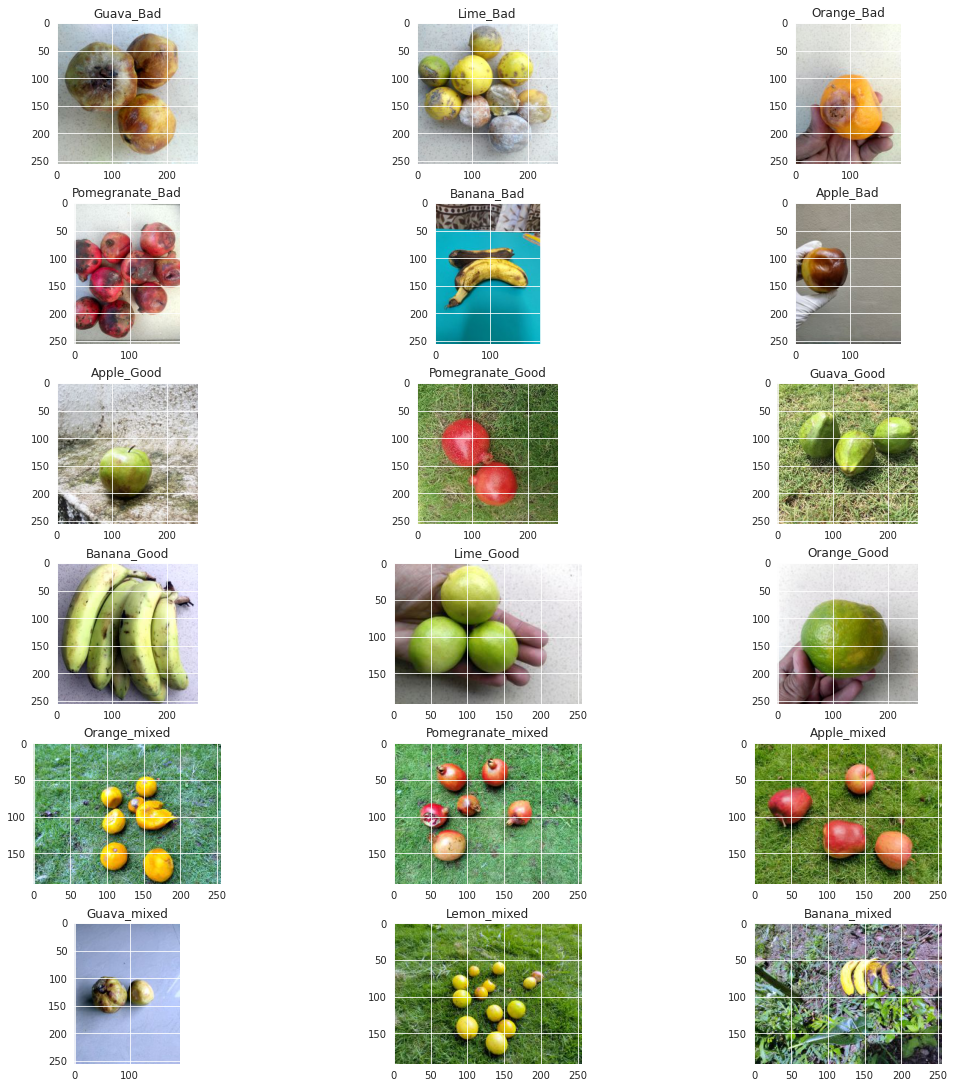

In [23]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15,15), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['labels'].unique():
    
    ax[j].imshow(plt.imread(df[df['labels']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

**Train Test split**

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=123)

In [25]:
print(X_train.shape)
print(X_test.shape)

(15620, 2)
(3906, 2)


In [26]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                              validation_split=0.2)
testGen =ImageDataGenerator(preprocessing_function= preprocess_input)

X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                           x_col='filepaths', 
                                           y_col='labels',
                                           class_mode='categorical', 
                                           subset='training', 
                                           batch_size=32)

X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                         x_col='filepaths', 
                                         y_col='labels',
                                         class_mode='categorical', 
                                         subset='validation',
                                         batch_size=32)

X_test_img =testGen.flow_from_dataframe(dataframe=X_test, 
                                        x_col='filepaths', 
                                        y_col='labels',
                                        class_mode='categorical', 
                                        batch_size=32, 
                                        shuffle=False)

Found 12496 validated image filenames belonging to 18 classes.
Found 3124 validated image filenames belonging to 18 classes.
Found 3906 validated image filenames belonging to 18 classes.


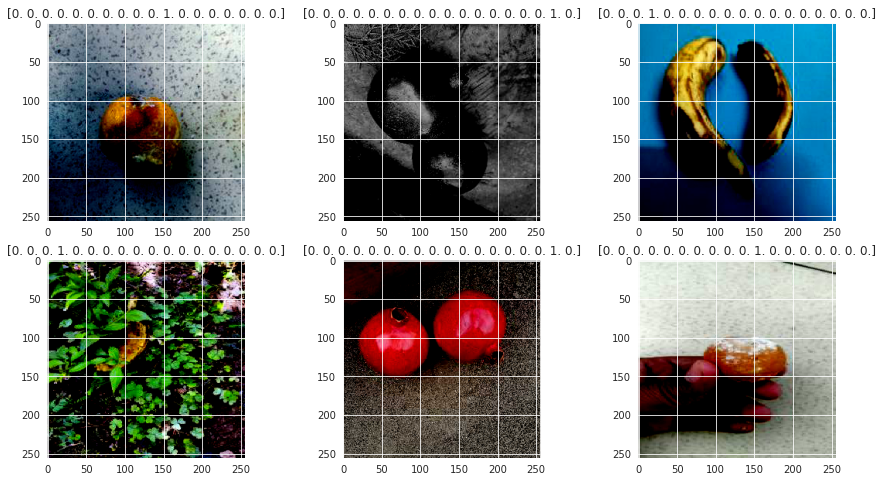

In [28]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = X_test_img.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    #plt.show()
    j=j+1

In [29]:
X_test_img[0][0].shape

(32, 256, 256, 3)

In [30]:
image_shape=(256,256,3)

In [31]:
X_train_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [32]:
X_val_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [33]:
X_test_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [34]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

**Feature extraction**

In [35]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
#Membuat base model dari pre-trained model dengan Inception ResNetV2
pre_trained= InceptionResNetV2(include_top=False, 
                               input_shape=image_shape)

#Freeze the convolutional base
pre_trained.trainable=False

inputs = pre_trained.input

x = data_augmentation(inputs)
x = pre_trained(x, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(128, activation='relu')(x)
output=Dense(18, activation='softmax')(x)


model = Model(inputs=inputs, outputs=output)

#Compile the model
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

219070464/219055592 [==============================] - 6s 0us/step


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

Train the model

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)

initial_epoch = 10
results = model.fit(X_train_img,epochs= initial_epoch,
                              validation_data=X_val_img,
                                callbacks=[early_stop])

Epoch 1/10
391/391 [==============================] - 283s 672ms/step - loss: 1.0836 - accuracy: 0.6933 - val_loss: 0.5200 - val_accuracy: 0.8364
Epoch 2/10
391/391 [==============================] - 220s 564ms/step - loss: 0.4814 - accuracy: 0.8524 - val_loss: 0.3634 - val_accuracy: 0.8873
Epoch 3/10
391/391 [==============================] - 219s 560ms/step - loss: 0.3561 - accuracy: 0.8885 - val_loss: 0.2927 - val_accuracy: 0.9113
Epoch 4/10
391/391 [==============================] - 221s 566ms/step - loss: 0.2883 - accuracy: 0.9105 - val_loss: 0.2531 - val_accuracy: 0.9190
Epoch 5/10
391/391 [==============================] - 219s 559ms/step - loss: 0.2488 - accuracy: 0.9212 - val_loss: 0.2147 - val_accuracy: 0.9334
Epoch 6/10
391/391 [==============================] - 221s 566ms/step - loss: 0.2125 - accuracy: 0.9336 - val_loss: 0.1966 - val_accuracy: 0.9353
Epoch 7/10
391/391 [==============================] - 224s 572ms/step - loss: 0.1926 - accuracy: 0.9393 - val_loss: 0.1859 -

Plot Learning curves



Text(0.5, 1.0, 'Loss')

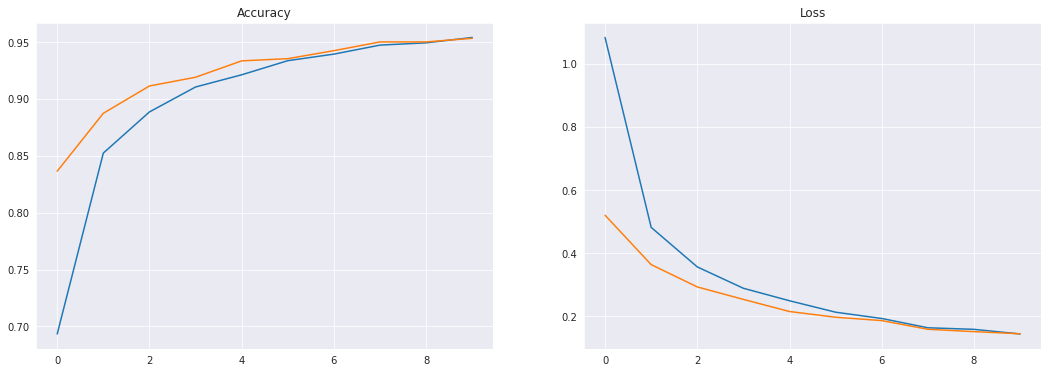

In [38]:

result_df = pd.DataFrame(results.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result_df[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result_df[['loss','val_loss']])
ax[1].set_title("Loss")

**Model Prediction**

In [39]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

In [43]:
pred

array([16, 15, 11, ...,  4, 12, 11])

In [41]:
X_test_img.class_indices.items()

dict_items([('Apple_Bad', 0), ('Apple_Good', 1), ('Apple_mixed', 2), ('Banana_Bad', 3), ('Banana_Good', 4), ('Banana_mixed', 5), ('Guava_Bad', 6), ('Guava_Good', 7), ('Guava_mixed', 8), ('Lemon_mixed', 9), ('Lime_Bad', 10), ('Lime_Good', 11), ('Orange_Bad', 12), ('Orange_Good', 13), ('Orange_mixed', 14), ('Pomegranate_Bad', 15), ('Pomegranate_Good', 16), ('Pomegranate_mixed', 17)])

In [ ]:
labels = {
    16 : "Apple"
}

In [ ]:
labels[1]

In [40]:
pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [44]:
pred_df.head()

,filepaths,labels,pred
8323,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Good,Pomegranate_Good
4204,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Bad,Pomegranate_Bad
16867,../input/fruitnet-indian-fruits-dataset-with-q...,Lime_Good,Lime_Good
4413,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Bad,Pomegranate_Bad
12590,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Good,Pomegranate_Good


Accuracy Score: 0.9572452636968766


<AxesSubplot:>

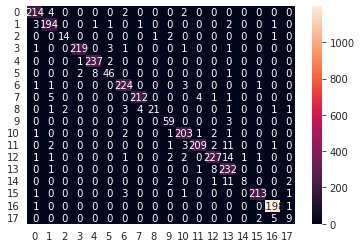

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'],pred_df['pred']), annot=True, fmt='2d')

                                               filepaths            labels  \
8323   ../input/fruitnet-indian-fruits-dataset-with-q...  Pomegranate_Good   
4204   ../input/fruitnet-indian-fruits-dataset-with-q...   Pomegranate_Bad   
16867  ../input/fruitnet-indian-fruits-dataset-with-q...         Lime_Good   
4413   ../input/fruitnet-indian-fruits-dataset-with-q...   Pomegranate_Bad   
12590  ../input/fruitnet-indian-fruits-dataset-with-q...  Pomegranate_Good   
14868  ../input/fruitnet-indian-fruits-dataset-with-q...        Guava_Good   

                   pred  
8323   Pomegranate_Good  
4204    Pomegranate_Bad  
16867         Lime_Good  
4413    Pomegranate_Bad  
12590  Pomegranate_Good  
14868        Guava_Good  


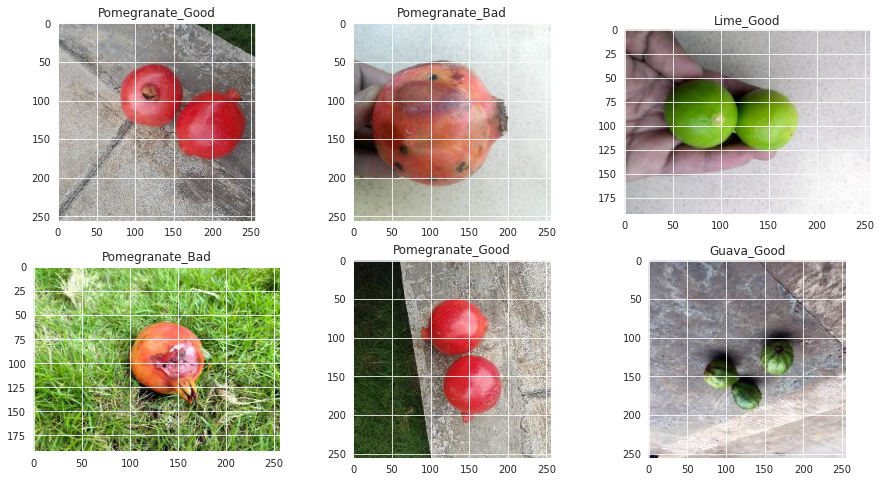

In [46]:
print(pred_df[pred_df['labels']==pred_df['pred']].head(6))
fig, ax=plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['labels']==pred_df['pred']].head(6).reset_index()
for i in range(0,6):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])

# **Fine Tuning**

Un-freeze the top layers of the model

In [48]:
pre_trained.trainable = True

In [47]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pre_trained.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  780


In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

In [51]:
len(model.trainable_variables)

494

In [52]:
fine_tune_epochs = 5
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(X_train_img,
                         epochs=total_epochs,
                         initial_epoch=10,
                         validation_data=X_val_img)

Epoch 11/15
391/391 [==============================] - 404s 950ms/step - loss: 0.0864 - accuracy: 0.9707 - val_loss: 0.0704 - val_accuracy: 0.9776
Epoch 12/15
391/391 [==============================] - 367s 938ms/step - loss: 0.0424 - accuracy: 0.9860 - val_loss: 0.0396 - val_accuracy: 0.9882
Epoch 13/15
391/391 [==============================] - 368s 940ms/step - loss: 0.0268 - accuracy: 0.9914 - val_loss: 0.0404 - val_accuracy: 0.9894
Epoch 14/15
391/391 [==============================] - 363s 928ms/step - loss: 0.0215 - accuracy: 0.9927 - val_loss: 0.0327 - val_accuracy: 0.9917
Epoch 15/15
391/391 [==============================] - 369s 945ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0216 - val_accuracy: 0.9942


In [53]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']


In [54]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

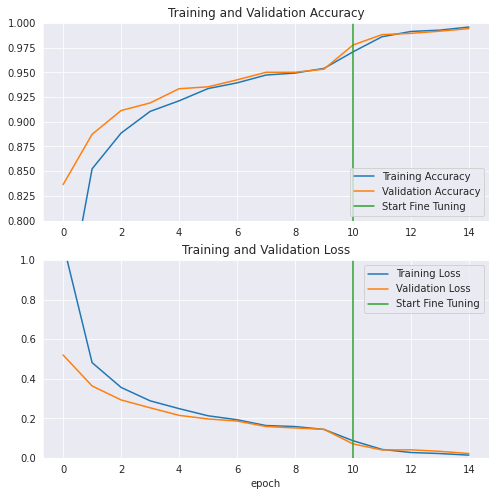

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10,10],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
loss, accuracy = model.evaluate(X_test_img)
print('Test accuracy :', accuracy)

123/123 [==============================] - 56s 454ms/step - loss: 0.0189 - accuracy: 0.9954
Test accuracy : 0.9953917264938354


In [62]:
model.save("/kaggle/working/model_fruitNet.h5")

In [81]:
class_names = list(X_train_img.class_indices.keys())

In [88]:
X_test.head()

,filepaths,labels
8323,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Good
4204,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Bad
16867,../input/fruitnet-indian-fruits-dataset-with-q...,Lime_Good
4413,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Bad
12590,../input/fruitnet-indian-fruits-dataset-with-q...,Pomegranate_Good


In [1]:
from tensorflow.keras.preprocessing import image

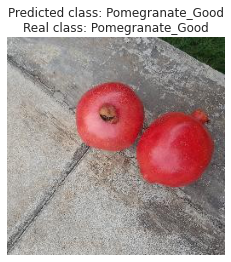

In [89]:
import matplotlib.pyplot as plt

# Load an image for prediction
img_path = X_test["filepaths"].values[0]
real_class = X_test["labels"].values[0]
img = image.load_img(img_path, target_size=(256, 256))  

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make prediction
prediction = model.predict(img_array) [0-1] (1,18)

predicted_class = np.argmax(prediction)

# Plot the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class and real class
plt.title("Predicted class: " + class_names[predicted_class] + "\nReal class: " + real_class)
plt.show()

In [1]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/model1/model_fruitNet.h5")

In [2]:
class_names = ['Apple_Bad','Apple_Good', 'Apple_mixed','Banana_Bad',
               'Banana_Good','Banana_mixed', 'Guava_Bad', 'Guava_Good','Guava_mixed',
               'Lemon_mixed', 'Lime_Bad', 'Lime_Good','Orange_Bad', 'Orange_Good',
               'Orange_mixed','Pomegranate_Bad','Pomegranate_Good','Pomegranate_mixed']

[[5.23952132e-11 1.03739225e-07 2.52198680e-13 8.23363422e-08
  7.26525286e-07 9.99999046e-01 3.94228705e-10 2.18088004e-12
  1.19239453e-11 2.24581765e-15 3.33790782e-15 1.83571623e-18
  6.31084405e-14 3.68799469e-16 1.75416471e-13 3.74862275e-09
  1.54012765e-14 6.39953064e-12]]


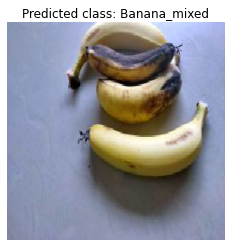

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

# Load an image for prediction
img_path = "/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Mixed Qualit_Fruits/Banana/IMG20200729183056.jpg"
img = image.load_img(img_path, target_size=(256, 256))  

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make prediction
prediction = model.predict(img_array) # [0-1] (1,18)

print(prediction)

predicted_class = np.argmax(prediction)

# Plot the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class and real class
plt.title("Predicted class: " + class_names[predicted_class])
plt.show()

In [2]:
pip install gradio   # run

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 51.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.9 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5600 sha256=aadb51cc48cda7c3e4735ea3dc8a7957506c62345ddc2f2140a91e77c24b7cc8
  Stored in directory: /root/.cache/pip/wheels/81/c3/08/a4932aee56b934891932e4a1b189604f27d3d4e92b2ecd5ed4
Successfully built ffmpy
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1
ERROR: pip's dependency resolver does not currently take into account all th

In [1]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

# Load the model
model = load_model("/kaggle/input/model1/model_fruitNet.h5")

# Define class names
class_names = ['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad',
               'Banana_Good', 'Banana_mixed', 'Guava_Bad', 'Guava_Good', 'Guava_mixed',
               'Lemon_mixed', 'Lime_Bad', 'Lime_Good', 'Orange_Bad', 'Orange_Good',
               'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']

def classify_fruit(input_image):
    # Preprocess the image
    img = tf.image.resize(input_image, (256, 256))
    img_array = image.img_to_array(img)
    
    # Create a writeable copy of the array
    img_array = np.array(img_array, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make array writeable and preprocess
    img_array.setflags(write=1)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Create result dictionary with confidences for all classes
    confidences = {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}
    
    return {class_name: conf for class_name, conf in sorted(confidences.items(), key=lambda x: x[1], reverse=True)}

# Create Gradio interface
iface = gr.Interface(
    fn=classify_fruit,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=5),
    title="Fruit Quality Classification",
    description="Upload an image of a fruit to classify its quality (good, bad, or mixed).",
    examples=[
        ["/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits/Banana_Bad/IMG20200729190307.jpg"],
        ["/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Good Quality_Fruits/Lime_Good/IMG20200728131548.jpg"],
        ["/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Mixed Qualit_Fruits/Guava/IMG20200728131718.jpg"]
    ],
    theme=gr.themes.Soft()
)

# Launch the interface
iface.launch()

ModuleNotFoundError: No module named 'gradio'